In [16]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow import keras

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics import r2_score
    
import matplotlib.pyplot as plt

In [17]:
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools

In [19]:
csi = pd.read_csv('/Users/msstark/Desktop/Brandeis/S2/Computer Simulation/final project/Project Package_JessieDu,ShirleyLi/Data//csi_updated_full.csv')
csi.drop('Unnamed: 0',axis = 1,inplace=True)
csi.set_index('Date',inplace=True)
csi.dropna(inplace=True)
csi.columns
csi['retv'] = (csi['retv']/100).copy()
# For the purpose of constructing training dataset for RNN, we need our data to be able to divided by 20
csi = csi.iloc[:-15,:].copy()

In [3]:
price = pd.read_csv('/Users/msstark/Desktop/Brandeis/S2/Computer Simulation/final project/Project Package_JessieDu,ShirleyLi/Data/csi300_clean_new.csv')
price.set_index('Date',inplace=True)
price = price[price.index >= '2005-02-01'].copy()
price = price[price.index <= '2022-03-14'].copy()


In [6]:
price.head()

,Unnamed: 0,Close,Open,High,Low,Vol.,Change %,Day,Month,Year,log_dsprd,lag_Close,log_ret,retv,csi_20day_vol,csi_quant_ret,exR_quant_ret
Date,,,,,,,,,,,,,,,,,
2005-02-01,19,955.95,953.33,965.48,952.74,7.43K,0.11%,1,2,2005,2.544747,954.88,0.001120,0.000060,0.011490,-0.018598,NaN
2005-02-02,20,1006.91,956.70,1006.93,956.70,17.06K,5.33%,2,2,2005,3.916612,955.95,0.051936,0.266144,0.016141,-0.018598,0.0
2005-02-03,21,993.22,1005.56,1014.19,992.16,16.98K,-1.36%,3,2,2005,3.092405,1006.91,-0.013689,0.019701,0.016295,-0.018598,0.0
2005-02-04,22,1016.86,992.25,1021.03,989.94,15.74K,2.38%,4,2,2005,3.436886,993.22,0.023523,0.053712,0.017099,-0.018598,0.0
2005-02-16,23,1023.58,1023.32,1033.25,1018.49,12.13K,0.66%,16,2,2005,2.691921,1016.86,0.006587,0.003894,0.017019,-0.018598,0.0


In [11]:
p = price[['Close']].copy()
price_df = tsatools.add_trend(p, trend='ctt')
price_lm = sm.ols(formula='Close ~ trend + trend_squared', data = price_df).fit()

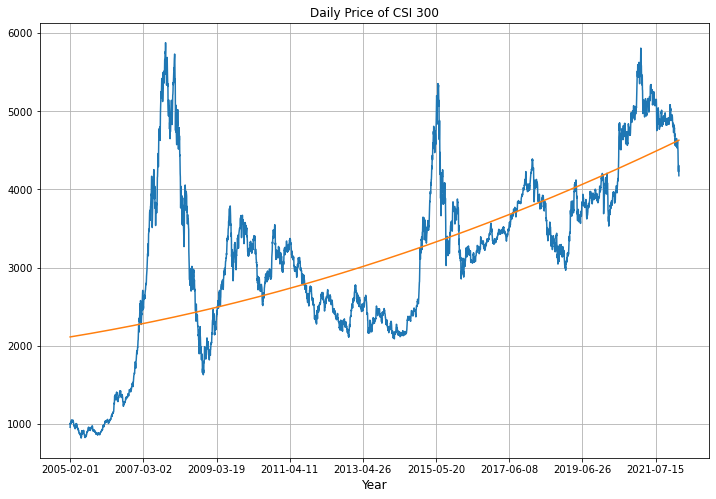

In [15]:
plt.figure(figsize=(12,8))
plt.plot(price['Close'])
plt.plot(price_lm.predict(price_df))
plt.xlabel('Year',fontsize = 12)
plt.title('Daily Price of CSI 300')
plt.xticks(np.arange(0, len(price)+1, 500))
plt.grid()

In [20]:
csi.head()

,Day,Month,log_dsprd,log_ret,retv,csi_20day_vol,csi_rstar,exR_rstar,hsi_rstar,sse_rstar,corn_rstar,soybean_rstar,heat_rstar,bond_rstar,platinum_rstar,palladium_rstar
Date,,,,,,,,,,,,,,,,
2005-02-01,1,2,2.544747,0.001120,5.978137e-07,0.011490,-0.018598,0.0,-0.015621,-0.020983,-0.023340,-0.025285,-0.028649,-0.020175,-0.009050,-0.022463
2005-02-02,2,2,3.916612,0.051936,2.661441e-03,0.016141,-0.018598,0.0,-0.010293,-0.020983,-0.023340,-0.025285,-0.028649,-0.015531,-0.009050,-0.022463
2005-02-03,3,2,3.092405,-0.013689,1.970113e-04,0.016295,-0.018598,0.0,-0.010293,-0.020983,-0.023340,-0.025285,-0.027304,-0.015531,-0.009050,-0.025156
2005-02-04,4,2,3.436886,0.023523,5.371172e-04,0.017099,-0.018598,0.0,-0.010229,-0.020983,-0.023340,-0.025285,-0.027304,-0.015531,-0.008569,-0.025156
2005-02-16,16,2,2.691921,0.006587,3.893873e-05,0.017019,-0.018598,0.0,-0.010229,-0.015723,-0.015164,-0.014595,-0.037745,-0.010585,-0.019109,-0.021233


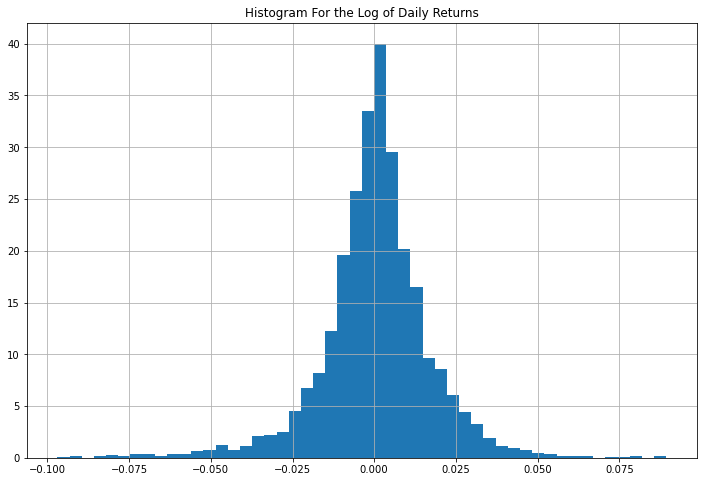

In [21]:
plt.figure(figsize=(12,8))
plt.hist(csi['log_ret'].to_numpy(),bins=50,histtype='bar',density = True)
plt.title('Histogram For the Log of Daily Returns')
plt.grid()
plt.show()

In [22]:
# Normality Test
def normal_test(x):
    skew = stats.skew(x,bias=True)
    kurt = stats.kurtosis(x,fisher = False)
    JB   = stats.jarque_bera(x)
    return skew,kurt,JB.pvalue
skew,kurt,pvalue = normal_test(csi['log_ret'])
print('log of daily return')
print('Skewness: ',skew)
print('kurtosis: ',kurt)
print('JB test p-value: ',pvalue)

log of daily return
Skewness:  -0.519882274392192
kurtosis:  7.015832817716407
JB test p-value:  0.0


### Outlier Detection

In [6]:
# upper and lower bound for ooutlier
upper1 = np.mean(csi['log_ret'])+3*np.std(csi['log_ret'])
lower1 = np.mean(csi['log_ret'])-3*np.std(csi['log_ret'])
print('Upper Bound: ',upper1)
print('Lower Bound: ',lower1)

Upper Bound:  0.05076550155935056
Lower Bound:  -0.050056258062972


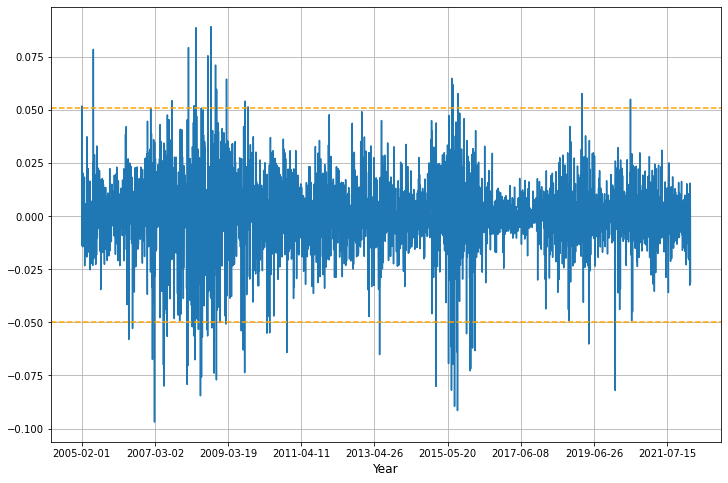

In [10]:
plt.figure(figsize = (12,8))
plt.plot(csi['log_ret'])
plt.xlabel('Year',fontsize = 12)
#plt.title('Daily Log Return')
plt.axhline(y = upper1,color='orange',linestyle='--')
plt.axhline(y = lower1,color='orange',linestyle='--')
plt.xticks(np.arange(0, len(csi)+1, 500))
plt.grid()

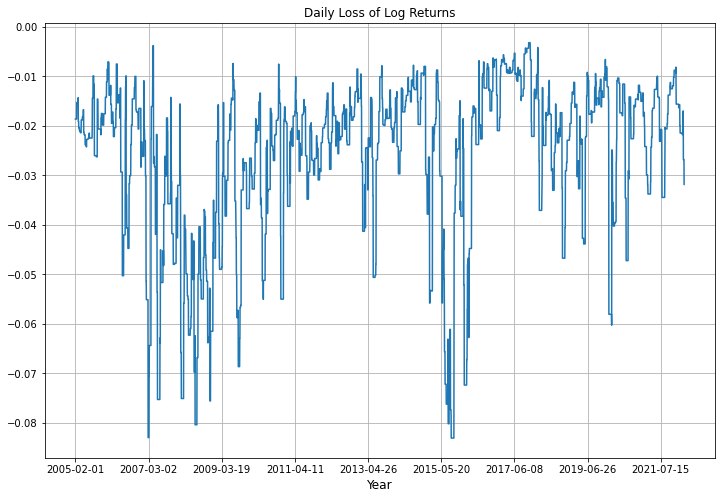

In [4]:
plt.figure(figsize=(12,8))
plt.plot(csi['csi_rstar'])
plt.xlabel('Year',fontsize = 12)
plt.title('Daily Loss of Log Returns')
plt.xticks(np.arange(0, len(csi)+1, 500))
plt.grid()

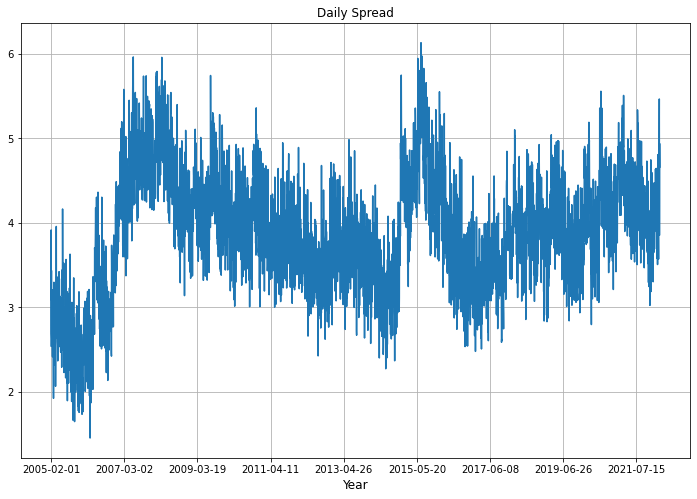

In [11]:
plt.figure(figsize=(12,8))
plt.plot(csi['log_dsprd'])
plt.xlabel('Year',fontsize = 12)
plt.title('Daily Spread')
plt.xticks(np.arange(0, len(csi)+1, 500))
plt.grid()

## Conventional Method

### Data Description

In [23]:
print(csi[['csi_20day_vol','log_ret','retv']].describe())

       csi_20day_vol      log_ret          retv
count    4160.000000  4160.000000  4.160000e+03
mean        0.015050     0.000355  2.823619e-04
std         0.007455     0.016806  6.925817e-04
min         0.002641    -0.096952  1.594519e-12
25%         0.009959    -0.007094  1.112883e-05
50%         0.012951     0.000849  6.097306e-05
75%         0.018535     0.008567  2.448692e-04
max         0.046140     0.089309  9.466983e-03


### Train-Test Split

In [24]:
csi['EMA']  = np.sqrt(csi['retv'].ewm(alpha=(1.-0.94),adjust=False).mean())
train, test = csi[:-520].copy(), csi[-520:].copy()
print('Training Set: ',train.shape)
print('Testing Set: ',test.shape)

Training Set:  (3640, 17)
Testing Set:  (520, 17)


In [31]:
train

,Day,Month,log_dsprd,log_ret,retv,csi_20day_vol,csi_rstar,exR_rstar,hsi_rstar,sse_rstar,...,soybean_rstar,heat_rstar,bond_rstar,platinum_rstar,palladium_rstar,EMA,MArstar,Erstar,lag_retv,lag_ret
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-01,1,2,2.544747,0.001120,5.978137e-07,0.011490,-0.018598,0.000000,-0.015621,-0.020983,...,-0.025285,-0.028649,-0.020175,-0.009050,-0.022463,0.000773,-0.023956,-0.001183,NaN,NaN
2005-02-02,2,2,3.916612,0.051936,2.661441e-03,0.016141,-0.018598,0.000000,-0.010293,-0.020983,...,-0.025285,-0.028649,-0.015531,-0.009050,-0.022463,0.012659,-0.033817,-0.025568,5.978137e-07,0.001120
2005-02-03,3,2,3.092405,-0.013689,1.970113e-04,0.016295,-0.018598,0.000000,-0.010293,-0.020983,...,-0.025285,-0.027304,-0.015531,-0.009050,-0.025156,0.012746,-0.034144,-0.025746,2.661441e-03,0.051936
2005-02-04,4,2,3.436886,0.023523,5.371172e-04,0.017099,-0.018598,0.000000,-0.010229,-0.020983,...,-0.025285,-0.027304,-0.015531,-0.008569,-0.025156,0.013599,-0.035848,-0.027497,1.970113e-04,-0.013689
2005-02-16,16,2,2.691921,0.006587,3.893873e-05,0.017019,-0.018598,0.000000,-0.010229,-0.015723,...,-0.014595,-0.037745,-0.010585,-0.019109,-0.021233,0.013273,-0.035678,-0.026828,5.371172e-04,0.023523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-10,10,1,3.481240,-0.000286,4.001151e-07,0.008989,-0.012097,-0.003984,-0.008135,-0.013258,...,-0.010798,-0.023335,-0.011443,-0.024082,-0.037084,0.008050,-0.018655,-0.016112,1.495951e-04,0.012578
2020-01-13,13,1,4.014399,0.009755,8.851274e-05,0.008161,-0.012097,-0.004056,-0.008135,-0.013258,...,-0.010798,-0.023868,-0.011443,-0.024082,-0.037084,0.008138,-0.016900,-0.016292,4.001151e-07,-0.000286
2020-01-14,14,1,3.567559,-0.003360,1.373697e-05,0.008141,-0.012097,-0.004056,-0.008135,-0.013258,...,-0.010798,-0.023868,-0.011443,-0.024082,-0.037084,0.007942,-0.016857,-0.015890,8.851274e-05,0.009755


### Moving Average

In [26]:
ret_mean = np.mean(train['log_ret'])

In [32]:
# historical critical value for MA
MAcrit = np.percentile(((train['log_ret']-ret_mean)/train['csi_20day_vol']),100*0.025)

# In sample
MArstar  = ret_mean + train['csi_20day_vol'] * MAcrit
train['MArstar'] = MArstar
etempIn = train['log_ret'] < train['MArstar'].shift(1) 
insampleExcep = pd.DataFrame(etempIn,columns = ['MA'])
print('MA IS exceptions ', np.mean(insampleExcep['MA']))

# Out of sample
MArstar_oos     = ret_mean + test['csi_20day_vol'] * MAcrit
test['MArstar'] = MArstar_oos
etemp = test['log_ret'] < test['MArstar'].shift(1) 
exceptions = pd.DataFrame(etemp,columns = ['MA'])
print('MA OOS exceptions ', np.mean(exceptions['MA']))

MA IS exceptions  0.03461538461538462
MA OOS exceptions  0.028846153846153848


### Exponential Wighted Moving Average

In [33]:
# historical critical value for EWMA
EMAcrit = np.percentile(((train['log_ret']-ret_mean)/train['EMA']),100*0.025)

Erstar  = ret_mean + train['EMA'] * EMAcrit
train['Erstar']   = Erstar
insampleExcep['EMA'] = train['log_ret'] < train['Erstar'].shift(1) 
print('EMA IS exceptions ', np.mean(insampleExcep['EMA']))


Erstar_oos  = ret_mean + test['EMA'] * EMAcrit
test['Erstar'] = Erstar_oos
exceptions['EMA']   = test['log_ret'] < test['Erstar'].shift(1) 
print('EMA OOS exceptions ', np.mean(exceptions['EMA']))

EMA IS exceptions  0.03406593406593406
EMA OOS exceptions  0.04038461538461539


### GARCH(1,1)

In [29]:
# Using maximum likelihood function find the best parameter for GARCH(1,1)
def garch(alpha0,alpha1,beta,data):
    T = len(data)
    sigmasq  = np.zeros(T)
    for i in range(T):        
        if i == 0:
            sigmasq[i] =  alpha0/(1.-alpha1-beta)
        else:
            sigmasq[i] = alpha0 + alpha1*(train['lag_ret'][i]-ret_mean)**2. + beta*train['lag_retv'][i]
    return sigmasq


def likelihood(parameters):
    alpha0 = parameters[0]
    alpha1 = parameters[1]
    beta   = parameters[2]
    
    sigmasq = garch(alpha0,alpha1,beta,train)
        
    LL = -np.sum(-np.log(sigmasq) - np.square(train['log_ret']-ret_mean)/sigmasq) 
    
    return LL

In [30]:
train['lag_retv'] = train['retv'].shift(1)
train['lag_ret']  = train['log_ret'].shift(1)
bound = [(None, 0.001), (0.01, 1), (0.01, 1)]
res = minimize(likelihood, np.array([2.e-6,0.1,0.89]),method='L-BFGS-B',bounds = bound,
                   options={'disp':True})
res.x

<ipython-input-29-ef1c59ca90ae>:20: RuntimeWarning: invalid value encountered in log
  LL = -np.sum(-np.log(sigmasq) - np.square(train['log_ret']-ret_mean)/sigmasq)


array([0.00023458, 0.21410852, 0.01      ])

In [44]:
# Setting parameters
beta   = res.x[2]
alpha1 = res.x[1]
alpha0 = res.x[0]

## In-sample test
T_train = len(train)
sigmasq = np.zeros(T_train)
sigmaLR    = alpha0/(1.-alpha1-beta)
sigmasq[0] = sigmaLR

# estimate variance using GARCH(1,1)
for t in range(1,T_train):       
    sigmasq[t] = alpha0 + alpha1*(train['lag_ret'][t]-ret_mean)**2. + beta*train['lag_retv'][t]  

# Garch model historical critical value
volGarch  = np.sqrt(sigmasq)
GarchCrit = np.percentile(((train['log_ret']-ret_mean)/volGarch),100*0.025)

# Find R-star
rstar_in  = ret_mean + volGarch * GarchCrit 

train['Garchstar']     = rstar_in
insampleExcep['Garch'] = train['log_ret'] < train['Garchstar'].shift(1) 
print('Garch IS exceptions ', np.mean(insampleExcep['Garch']))

## Out of sample test
T       = len(test)
sigmasq = np.zeros(T)
#initial value(current)
sigmaLR    = alpha0/(1.-alpha1-beta)
sigmasq[0] = sigmaLR

for t in range(1,T):       
    sigmasq[t] = alpha0 + alpha1 * (test['log_ret'][t-1]-ret_mean)**2. + beta*test['retv'][t-1]
    
rstar = ret_mean + np.sqrt(sigmasq) * GarchCrit 

test['Garchrstar'] = rstar
exceptions['Garch'] = test['log_ret'] < test['Garchrstar'].shift(1) 
print('Garch OOS exceptions ', np.mean(exceptions['Garch']))

Garch IS exceptions  0.0228021978021978
Garch OOS exceptions  0.007692307692307693


### Out of sample Exception and Violation Ratio

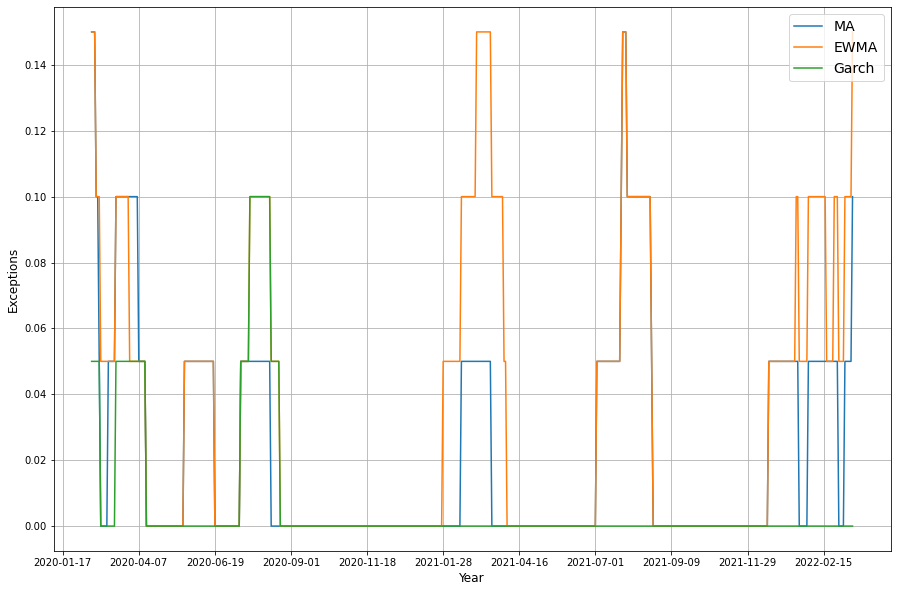

In [45]:
# rolling 20 days
exceptionsMAOOS = exceptions.rolling(window = 20).mean()

plt.figure(figsize=(15,10))
plt.plot(exceptionsMAOOS)

plt.legend(['MA','EWMA','Garch'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(test)+1, 50))
plt.grid()

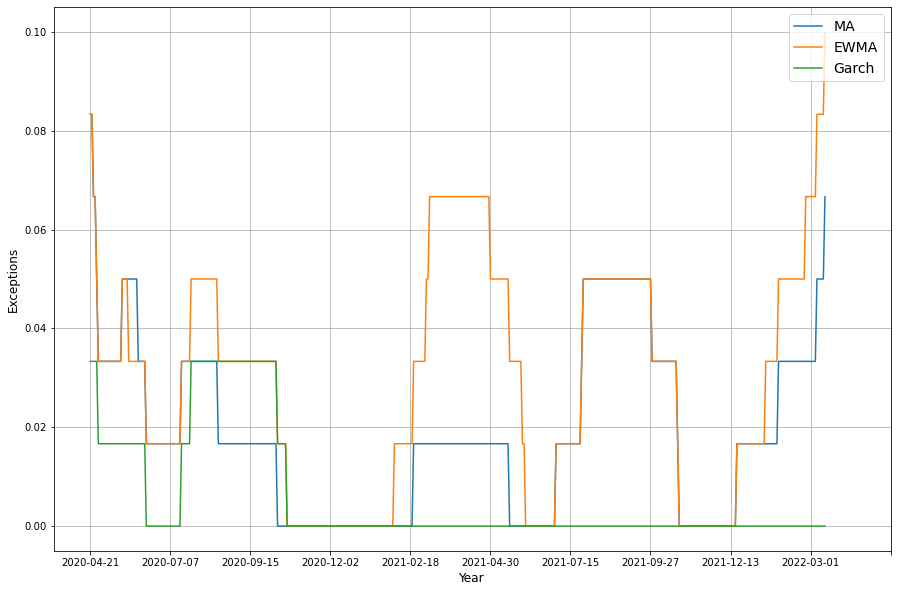

In [46]:
# rolling 60 days
exceptionsMAOOS1 = exceptions.rolling(window = 60).mean()

plt.figure(figsize=(15,10))
plt.plot(exceptionsMAOOS1[60:])

plt.legend(['MA','EWMA','Garch'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(test)+1, 50))
plt.grid()

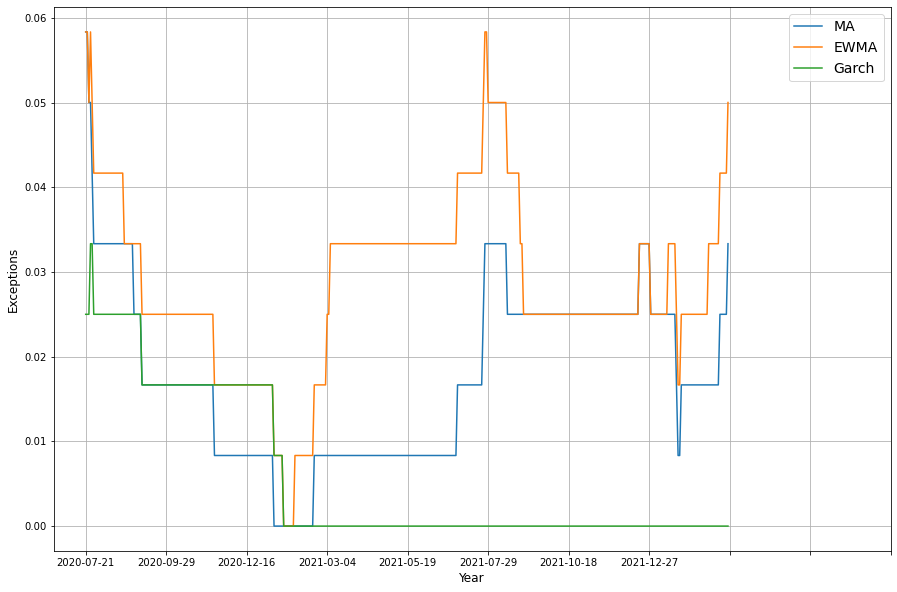

In [47]:
# rolling 120 days
exceptionsMAOOS2 = exceptions.rolling(window = 120).mean()

plt.figure(figsize=(15,10))
plt.plot(exceptionsMAOOS2[120:])

plt.legend(['MA','EWMA','Garch'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(test)+1, 50))
plt.grid()

In [48]:
# Violation Ratio
OV1 = list(np.sum(exceptions))
pT = 0.025*len(test)
VR1 = []
for o in OV1:
    VR1 += [o/pT]
print('OOS VR: ',VR1)

OOS VR:  [1.1538461538461537, 1.6153846153846154, 0.3076923076923077]


### In sample Exception and Violation Ratio

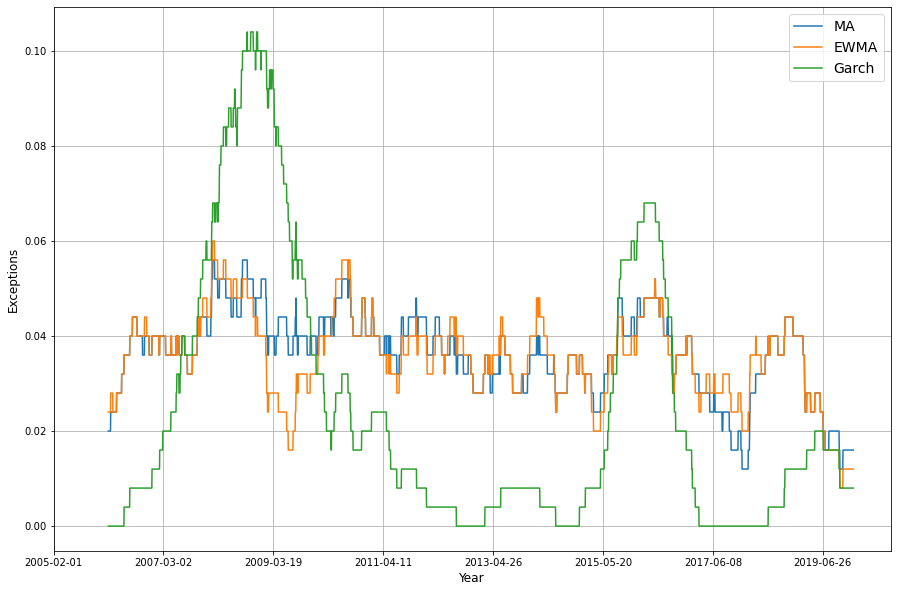

In [49]:
exceptionsMAIS = insampleExcep.rolling(window = 250).mean()

plt.figure(figsize=(15,10))
plt.plot(exceptionsMAIS)

plt.legend(['MA','EWMA','Garch'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(train)+1, 500))
plt.grid()

In [50]:
OV2 = list(np.sum(insampleExcep))
pT = 0.025*len(train)
VR2 = []
for o in OV2:
    VR2 += [o/pT]
print('OOS VR: ',VR2)

OOS VR:  [1.3846153846153846, 1.3626373626373627, 0.9120879120879121]


## ML-Prediction

### Data Description

In [12]:
# Feature selection
data1 = csi[['Month', 'log_dsprd', 'log_ret', 'retv', 'exR_rstar','hsi_rstar', 'sse_rstar', 'corn_rstar', 
             'soybean_rstar', 'heat_rstar', 'bond_rstar','platinum_rstar', 'palladium_rstar','csi_rstar']].copy()
train, test = data1[:-520].copy(), data1[-520:].copy()
data1.describe()

,Month,log_dsprd,log_ret,retv,exR_rstar,hsi_rstar,sse_rstar,corn_rstar,soybean_rstar,heat_rstar,bond_rstar,platinum_rstar,palladium_rstar,csi_rstar
count,4160.000000,4160.000000,4160.000000,4.160000e+03,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000
mean,6.579567,3.858178,0.000355,2.823619e-04,-0.002467,-0.021629,-0.024673,-0.027695,-0.023304,-0.034355,-0.023375,-0.024967,-0.033443,-0.026411
std,3.429279,0.712613,0.016806,6.925817e-04,0.001864,0.013014,0.015992,0.013490,0.011854,0.020605,0.018584,0.013972,0.020823,0.016435
min,1.000000,1.456287,-0.096952,1.594519e-12,-0.010950,-0.112463,-0.084287,-0.074593,-0.075359,-0.169654,-0.134058,-0.114449,-0.197240,-0.083049
25%,4.000000,3.399696,-0.007094,1.112883e-05,-0.003438,-0.025694,-0.031387,-0.033428,-0.028393,-0.040821,-0.029702,-0.028910,-0.040912,-0.032924
50%,7.000000,3.848444,0.000849,6.097306e-05,-0.002073,-0.018585,-0.019630,-0.024296,-0.019947,-0.029711,-0.018147,-0.022142,-0.028780,-0.021675
75%,9.000000,4.323338,0.008567,2.448692e-04,-0.001181,-0.013479,-0.013715,-0.018005,-0.015569,-0.021798,-0.010609,-0.016141,-0.020510,-0.015020
max,12.000000,6.130705,0.089309,9.466983e-03,0.000000,-0.000917,-0.003505,-0.004067,-0.002745,-0.006023,-0.001420,-0.002302,-0.000432,-0.003170


### Fuction to estimate model Accuracy

In [14]:
# measuring rolling forecast accuracy
def predAccuracy(X,y,X_test,y_test,best_model):
    X_new = X.copy()
    y_new = y.copy()
    R2  = []
    RMSE = []
    Y_pred = []
    i = 0
    while i < len(test):
        start = i
        end   = i+20
        X_test_new = X_test[start:end].copy()
        y_test_new = y_test[start:end].copy()
        best_model.fit(X_new,y_new)
        y_pred = best_model.predict(X_test_new)
        rmse = np.sqrt(mean_squared_error(y_test_new,y_pred))
        r2  = best_model.score(X_test_new,y_test_new)
        R2.append(r2)
        RMSE.append(rmse)
        Y_pred += list(y_pred)
        
        X_new = np.concatenate((X_new, X_test[start:end]), axis=0)
        y_new += y_test_new
        i +=20
    return R2,RMSE,Y_pred

### Ridge Regression

In [13]:
X = train.iloc[:,:-1].to_numpy()
y = train.iloc[:,-1].to_list()
X_test = test.iloc[:,:-1].to_numpy()
y_test = test.iloc[:,-1].to_list()

In [15]:
def regress_ridge(X,y,alphalist):    
    # 10 times validation
    TSsplit = TimeSeriesSplit(gap=0,n_splits=181, test_size = None)
    # creating pipeline to assemble several steps            
    fullModel   = Pipeline([('scaler',MinMaxScaler()),
                            ('ridge',Ridge())])
    param_grid  = {'ridge__alpha':alphalist}
    
    # using grid search to find the optimal parameter
    grid_search = GridSearchCV(fullModel,param_grid,
                               cv = TSsplit,return_train_score = True)
    grid_search.fit(X,y)   
    # store the grid search result
    result = pd.DataFrame(grid_search.cv_results_)[[
        'rank_test_score','mean_train_score',
        'mean_test_score','param_ridge__alpha']]
    
    best_model  = grid_search.best_estimator_    
    return result,best_model

In [16]:
alphalist = np.arange(0.1,1.01,0.1)
resultR,best_modelR = regress_ridge(X,y,alphalist)
print(resultR)

   rank_test_score  mean_train_score  mean_test_score param_ridge__alpha
0               10          0.958983        -0.596325                0.1
1                9          0.958695        -0.538606                0.2
2                5          0.958422        -0.521504                0.3
3                2          0.958139        -0.516336                0.4
4                1          0.957843        -0.516045                0.5
5                3          0.957534        -0.517970                0.6
6                4          0.957215        -0.520896                0.7
7                6          0.956886        -0.524221                0.8
8                7          0.956548        -0.527634                0.9
9                8          0.956204        -0.530981                1.0


#### 20-day rolling forecast

In [17]:
R2_ridge,RMSE_ridge,pred_ridge = predAccuracy(X,y,X_test,y_test,best_modelR)
ridge_r2 = np.mean(R2_ridge)
ridge_rmse = np.mean(RMSE_ridge)
print('R2:',ridge_r2)
print('RMSE:',ridge_rmse)

R2: -5.500508992273935
RMSE: 0.0030976773144561188


#### 2 years one-time forecast

In [19]:
best_modelR.fit(X,y)
ridge_r2_1   = best_modelR.score(X_test,y_test)
y_pred       = best_modelR.predict(X_test)
ridge_rmse_1 = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2: ',ridge_r2_1)
print('RMSE: ',ridge_rmse_1)

R2:  0.8689444220471504
RMSE:  0.004232912098940559


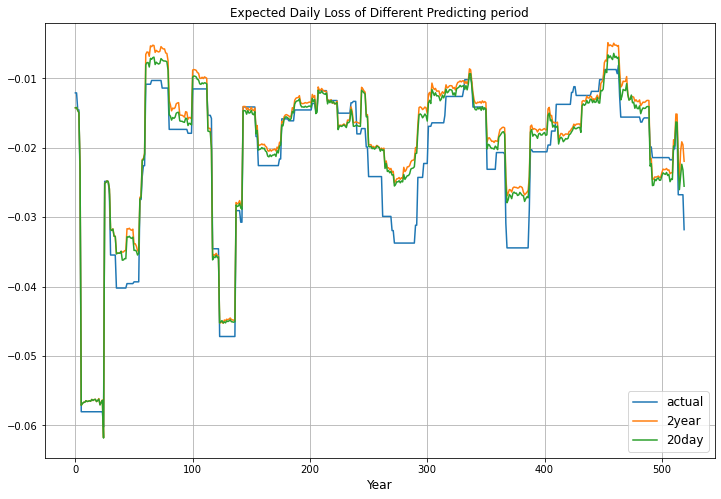

In [20]:
plt.figure(figsize=(12,8))
plt.plot(y_test,label='actual')
plt.plot(y_pred,label='2year')
plt.plot(pred_ridge,label='20day')
plt.xlabel('Year',fontsize = 12)
plt.title('Expected Daily Loss of Different Predicting period')
plt.grid()
plt.legend(loc='lower right',fontsize=12)

#### OOS Exception and VR

In [21]:
test['pred_rstarR'] = pred_ridge
etemp = test['log_ret'] < test['pred_rstarR'].shift(1) 
MLexceptions = pd.DataFrame(etemp,columns = ['Ridge Regression']).copy()
print('Ridge Regression exceptions ', np.mean(MLexceptions['Ridge Regression']))

Ridge Regression exceptions  0.07884615384615384


### Lasso Regression

In [22]:
def regress_Lasso(X,y,alphalist):    
    # 10 times validation, each time use 20 to validate
    TSsplit = TimeSeriesSplit(n_splits=181, test_size = None)
    # creating pipeline to assemble several steps
            
    fullModel   = Pipeline([('scaler',MinMaxScaler()),
                            ('lasso',Lasso())])
    param_grid  = {'lasso__alpha':alphalist}
    
    # using grid search to find the optimal parameter
    grid_search = GridSearchCV(fullModel,param_grid,cv = TSsplit,return_train_score = True)
    grid_search.fit(X,y)   
    # store the grid search result
    result = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_lasso__alpha']]
    
    best_model  = grid_search.best_estimator_    
    return result,best_model


In [23]:
alphalist = np.arange(0.000005,0.001,0.00005)
resultLS,best_modelLS = regress_Lasso(X,y,alphalist)
print(resultLS)

    rank_test_score  mean_train_score  mean_test_score param_lasso__alpha
0                 2          0.959064        -0.646062           0.000005
1                 1          0.952315        -0.533927           0.000055
2                 3          0.946238        -0.771390           0.000105
3                 4          0.941305        -0.948664           0.000155
4                 5          0.936386        -1.125371           0.000205
5                 6          0.930664        -1.353655           0.000255
6                 7          0.924124        -1.604450           0.000305
7                 8          0.916582        -1.880503           0.000355
8                 9          0.907952        -2.204634           0.000405
9                10          0.898270        -2.576953           0.000455
10               11          0.888185        -2.960159           0.000505
11               12          0.878330        -3.320479           0.000555
12               13          0.868415 

#### 20-day rolling forecast

In [24]:
R2_lasso,RMSE_lasso,pred_lasso = predAccuracy(X,y,X_test,y_test,best_modelLS)
lasso_r2  = np.mean(R2_lasso)
lasso_rmse = np.mean(RMSE_lasso)
print('R2:',lasso_r2)
print('RMSE:',lasso_rmse)

R2: -3.910358551619786
RMSE: 0.003000293588929333


#### 2-years one-time forecast

In [25]:
best_modelLS.fit(X,y)
lasso_r2_1  = best_modelLS.score(X_test,y_test)
y_pred      = best_modelLS.predict(X_test)
lasso_rmse_1 = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2: ',lasso_r2_1)
print('RMSE: ',lasso_rmse_1)

R2:  0.8856393275548884
RMSE:  0.003954119999628798


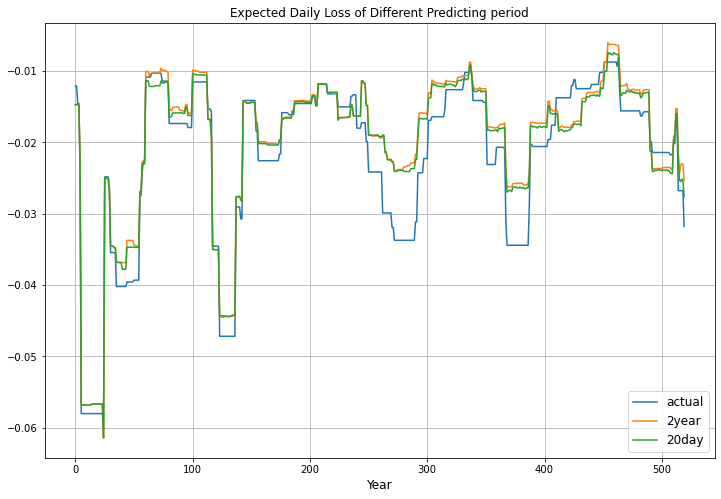

In [26]:
plt.figure(figsize=(12,8))
plt.plot(y_test,label='actual')
plt.plot(y_pred,label='2year')
plt.plot(pred_lasso,label='20day')
plt.xlabel('Year',fontsize = 12)
plt.title('Expected Daily Loss of Different Predicting period')
plt.grid()
plt.legend(loc='lower right',fontsize=12)

#### OOS Exception and VR

In [27]:
test['pred_rstarLS'] = pred_lasso
etemp = test['log_ret'] < test['pred_rstarLS'].shift(1) 
MLexceptions['Lasso Regression'] = test['log_ret'] < test['pred_rstarLS'].shift(1) 
print('Lasso Regression exceptions ', np.mean(MLexceptions['Lasso Regression']))

Lasso Regression exceptions  0.07692307692307693


### Random Forest Regression

In [28]:
def RF(X,y):
    param_grid={'n_estimators':[100],'max_depth':[10,25,50,100],'max_features':[3,5,10,13]}

    forestModel= RandomForestRegressor()

    # set up cross-validation shuffles
    TSsplit = TimeSeriesSplit(gap=0,n_splits=181, test_size = None)

    # set up search
    grid_search = GridSearchCV(forestModel,param_grid,cv=TSsplit,scoring='r2', 
                              return_train_score=True,n_jobs=1)
    # implement search
    
    grid_search.fit(X,y)
    result = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_test_score','param_n_estimators','param_max_depth','param_max_features']]
    
    best_model  = grid_search.best_estimator_    
    return result,best_model


In [29]:
resultRF,best_modelRF = RF(X,y)
print(resultRF)

    rank_test_score  mean_test_score param_n_estimators param_max_depth  \
0                16        -2.972923                100              10   
1                12        -1.221640                100              10   
2                 1        -0.578712                100              10   
3                 4        -0.682257                100              10   
4                13        -2.342094                100              25   
5                11        -1.180627                100              25   
6                 2        -0.607948                100              25   
7                 8        -0.749001                100              25   
8                15        -2.624930                100              50   
9                10        -1.066919                100              50   
10                5        -0.688201                100              50   
11                7        -0.746120                100              50   
12               14      

#### 20-day rolling forecast

In [30]:
R2_RF,RMSE_RF,pred_RF = predAccuracy(X,y,X_test,y_test,best_modelRF)
RF_r2   = np.mean(R2_RF)
RF_rmse = np.mean(RMSE_RF)
print('R2:',RF_r2)
print('RMSE:',RF_rmse)


R2: -7.274844805954957
RMSE: 0.0029987581399691095


#### 2 years one-time forecast

In [31]:
print('R2: ',best_modelRF.score(X_test,y_test))
y_predRF = best_modelRF.predict(X_test)
rmseRF   = np.sqrt(mean_squared_error(y_test,y_predRF))
print('RMSE: ',rmseRF)

R2:  0.9939326304542896
RMSE:  0.0009107762950887927


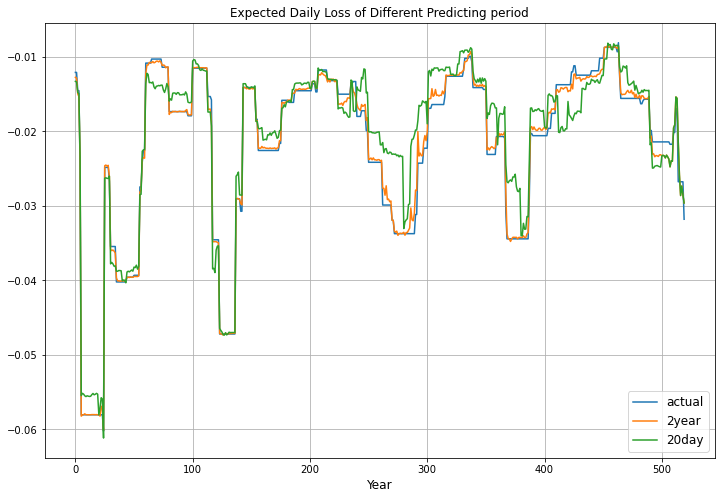

In [32]:
plt.figure(figsize=(12,8))
plt.plot(y_test,label='actual')
plt.plot(y_predRF,label='2year')
plt.plot(pred_RF,label='20day')
plt.xlabel('Year',fontsize = 12)
plt.title('Expected Daily Loss of Different Predicting period')
plt.grid()
plt.legend(loc='lower right',fontsize=12)

#### Exceptions and VR

In [33]:
test['pred_rstarRF'] = pred_RF
etemp = test['log_ret'] < test['pred_rstarRF'].shift(1) 
MLexceptions['Random Forest'] = test['log_ret'] < test['pred_rstarRF'].shift(1) 
print('Random Forest exceptions ', np.mean(MLexceptions['Random Forest']))

Random Forest exceptions  0.07884615384615384


### Gradient Boosted Tree

In [34]:
def xgbr(X,y):
    param_grid={'n_estimators':[100],'max_depth':[1,2,3],
                'max_features':[10,13],'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
    gbrt = GradientBoostingRegressor(validation_fraction=0.2,n_iter_no_change=10,tol=0.001)
    TSsplit = TimeSeriesSplit(gap=0,n_splits=181, test_size = None)

    # set up search
    grid_search = GridSearchCV(gbrt,param_grid,cv=TSsplit,scoring='r2', 
                              return_train_score=True,n_jobs=1)
    grid_search.fit(X,y)
    result = pd.DataFrame(grid_search.cv_results_)[['rank_test_score','mean_train_score','mean_test_score','param_n_estimators','param_max_depth','param_max_features']]
    
    best_model  = grid_search.best_estimator_    
    return result,best_model
 

In [35]:
resultGBT,best_modelGBT = xgbr(X,y)
print(resultGBT)

    rank_test_score  mean_train_score  mean_test_score param_n_estimators  \
0                32          0.000702       -66.235519                100   
1                36          0.001235       -66.717415                100   
2                31          0.001577       -66.189020                100   
3                34          0.001582       -66.601275                100   
4                33          0.001468       -66.377908                100   
5                35          0.001709       -66.618186                100   
6                30          0.012879       -65.936467                100   
7                29          0.014808       -65.683121                100   
8                25          0.017546       -65.018437                100   
9                28          0.019089       -65.195794                100   
10               27          0.019617       -65.154799                100   
11               26          0.020443       -65.113000                100   

#### 20-day forecast

In [36]:
R2_gbr,RMSE_gbr,pred_gbr = predAccuracy(X,y,X_test,y_test,best_modelGBT)
gbr_r2  = np.mean(R2_gbr)
gbr_rmse = np.mean(RMSE_gbr)
print('R2:',gbr_r2)
print('RMSE:',gbr_rmse)

R2: -6.882785119102517
RMSE: 0.003099932890425774


#### 2-years one-time forecast

In [37]:
print('R2: ',best_modelGBT.score(X_test,y_test))
y_predGbr = best_modelGBT.predict(X_test)
rmseGbr    = np.sqrt(mean_squared_error(y_test,y_predRF))
print('MSE: ',rmseGbr)

R2:  0.9417032342798884
MSE:  0.0009107762950887927


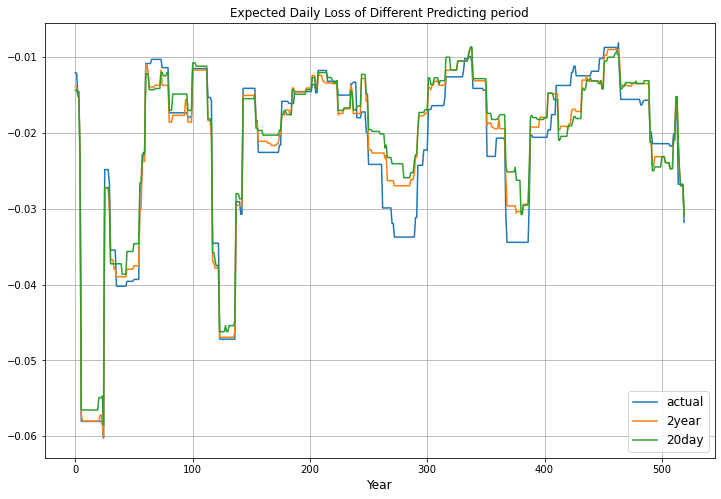

In [38]:
plt.figure(figsize=(12,8))
plt.plot(y_test,label='actual')
plt.plot(y_predGbr,label='2year')
plt.plot(pred_gbr,label='20day')
plt.xlabel('Year',fontsize = 12)
plt.title('Expected Daily Loss of Different Predicting period')
plt.grid()
plt.legend(loc='lower right',fontsize=12)

#### Exceptions and VR

In [39]:
test['pred_rstarGbr'] = pred_gbr
etemp = test['log_ret'] < test['pred_rstarGbr'].shift(1) 
MLexceptions['Gradient Boosting Trees'] = test['log_ret'] < test['pred_rstarGbr'].shift(1) 
print('Gradient Boosting Trees exceptions ', np.mean(MLexceptions['Gradient Boosting Trees']))

Gradient Boosting Trees exceptions  0.07307692307692308


### Recurrent Neural Network

In [40]:
def split_dataset(data):
    # split into approximately standard months
    train, test = data[:-520], data[-520:]
    # expand array dimension
    # restructure into windows of monthly data
    # now the train dataset is a 3D array 
    # with a length of (182*20*14): 182 months, each month has 20 days, each day has 13 predictors
    train = np.array(np.split(train, len(train)/20)) #(182*20*14)
    test  = np.array(np.split(test, len(test)/20)) #(26*20*14)
    return train, test

# evaluate one or more daily forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = []
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        # [:,i] => select the data for day i at each month
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store 20 scores(20 days)
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]): # 26 months
        for col in range(actual.shape[1]): # each month 20 days
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.5f' % s for s in scores])
    print('%s: [%.5f] %s' % (name, score, s_scores))


# convert history into inputs and outputs
# Rolling to build training dataset
def to_supervised(train, n_input, n_out=20):
    # flatten data => From 3D to 2D array; shape: 3640*13
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = [], []
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end  = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, :-1]
            x_input = x_input.reshape((len(x_input), 13))
            X.append(x_input)
            y.append(data[in_end:out_end, -1])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# train the model 
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters 
    verbose, epochs, batch_size = 2, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = keras.Sequential([
        keras.layers.LSTM(200, activation='sigmoid', input_shape=(n_timesteps, n_features)),
        keras.layers.Dense(100, activation='sigmoid'),
        keras.layers.Dense(n_outputs)])
    
    model.compile(loss='mse', optimizer='adam')
    # fit network
    es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=10, verbose=1, restore_best_weights=True)
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[es],validation_split=0.3)
    return model


# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :-1]
    # reshape into [1, n_input, 13] => the last month in the training data(20 days)
    input_x = input_x.reshape((1, len(input_x), 13))
    # forecast the next month
    yhat = model.predict(input_x, verbose=2) # shape: (1 x 20)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat


'''
Models will be evaluated using a scheme called walk-forward validation.
    n_input is provided that is used to define the number of prior observations 
    that the model will use as input in order to make a prediction.
'''
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of monthly data with a total of 182 months
    history = [x for x in train]
    # walk-forward validation over each month
    predictions = []
    for i in range(len(test)): # len(test) = 26 => 26 months, each month contains 20 days
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        # len(yhat_sequence[0]) = 20
        predictions.append(yhat_sequence) # predictions should have a length = len(test)
        # get real observation and add to history for predicting the next month
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions) # shape: 13 x 20
    # test: a 3D array of shape (26,20,13)
    # test[:, :, -1]: select all the target for 26 months, is a 2D array of shape (26,20)
    score, scores = evaluate_forecasts(test[:, :, -1], predictions)
    return score, scores,predictions,model.summary()


In [56]:
data2 = csi[['Month', 'log_dsprd', 'log_ret', 'retv', 'exR_rstar','hsi_rstar', 'sse_rstar', 'corn_rstar', 
             'soybean_rstar', 'heat_rstar', 'bond_rstar','platinum_rstar', 'palladium_rstar','csi_rstar']].copy()
data2.dropna(inplace=True)

trainRNN,testRNN = split_dataset(data2)

n_input = 20

score,scores,pred,model = evaluate_model(trainRNN.copy(), testRNN.copy(), n_input)
summarize_scores('lstm', score, scores)

pred_flat_rnn = pred.ravel()

Epoch 1/70
158/158 - 3s - loss: 0.0085 - val_loss: 3.1508e-04
Epoch 2/70
158/158 - 2s - loss: 2.7704e-04 - val_loss: 2.7447e-04
Epoch 3/70
158/158 - 3s - loss: 2.4027e-04 - val_loss: 2.4526e-04
Epoch 4/70
158/158 - 2s - loss: 2.1630e-04 - val_loss: 2.4123e-04
Epoch 5/70
158/158 - 2s - loss: 1.9259e-04 - val_loss: 2.1769e-04
Epoch 6/70
158/158 - 2s - loss: 1.7871e-04 - val_loss: 2.2695e-04
Epoch 7/70
158/158 - 2s - loss: 1.7714e-04 - val_loss: 2.3433e-04
Epoch 8/70
158/158 - 2s - loss: 1.6884e-04 - val_loss: 2.2289e-04
Epoch 9/70
158/158 - 2s - loss: 1.6376e-04 - val_loss: 1.5871e-04
Epoch 10/70
158/158 - 2s - loss: 1.7464e-04 - val_loss: 1.8076e-04
Epoch 11/70
158/158 - 2s - loss: 1.6866e-04 - val_loss: 1.9599e-04
Epoch 12/70
158/158 - 2s - loss: 1.5821e-04 - val_loss: 1.5528e-04
Epoch 13/70
158/158 - 2s - loss: 1.6390e-04 - val_loss: 1.4233e-04
Epoch 14/70
158/158 - 2s - loss: 1.7748e-04 - val_loss: 1.5229e-04
Epoch 15/70
158/158 - 2s - loss: 1.5276e-04 - val_loss: 3.4145e-04
Epoch 16

In [57]:
print('RMSE: ',score)
print('R2: ',r2_score(pred_flat_rnn,y_test))

RMSE:  0.013571530184287596
R2:  -2.8014620724266517


#### Exceptions

In [58]:
test['pred_rstarRNN'] = pred_flat_rnn
MLexceptions['RNN'] = test['log_ret'] < test['pred_rstarRNN'].shift(1) 
print('Recurrent Neural Network', np.mean(MLexceptions['RNN']))

Recurrent Neural Network 0.023076923076923078


### Plot of Exceptions and Violation Ratio

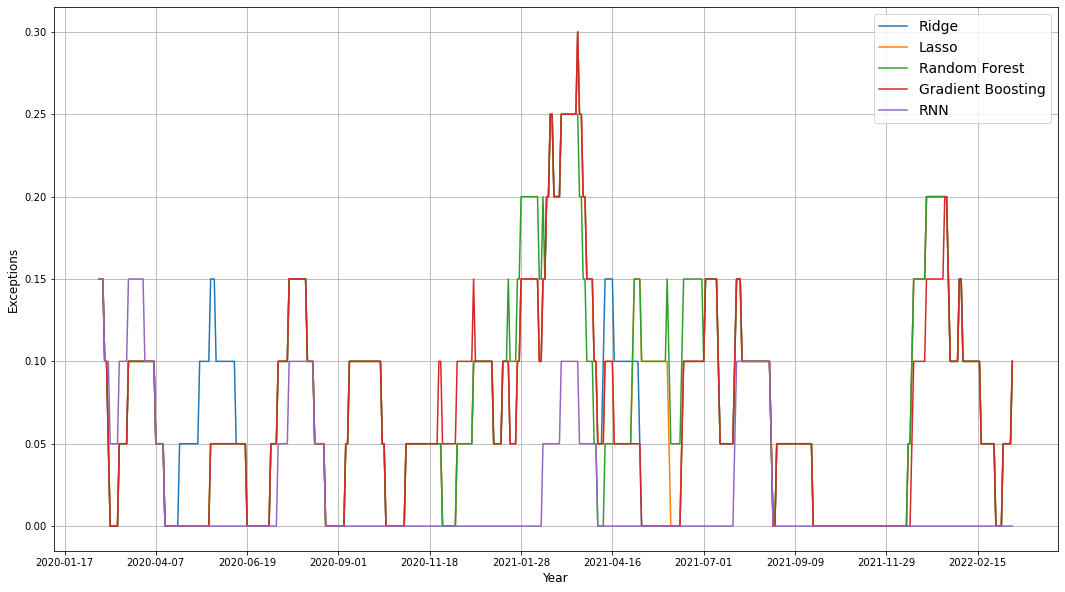

In [59]:
MLexceptionsMA = MLexceptions.rolling(window = 20).mean()

plt.figure(figsize=(18,10))
plt.plot(MLexceptionsMA)

plt.legend(['Ridge','Lasso','Random Forest','Gradient Boosting','RNN'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(test)+1, 50))
plt.grid()

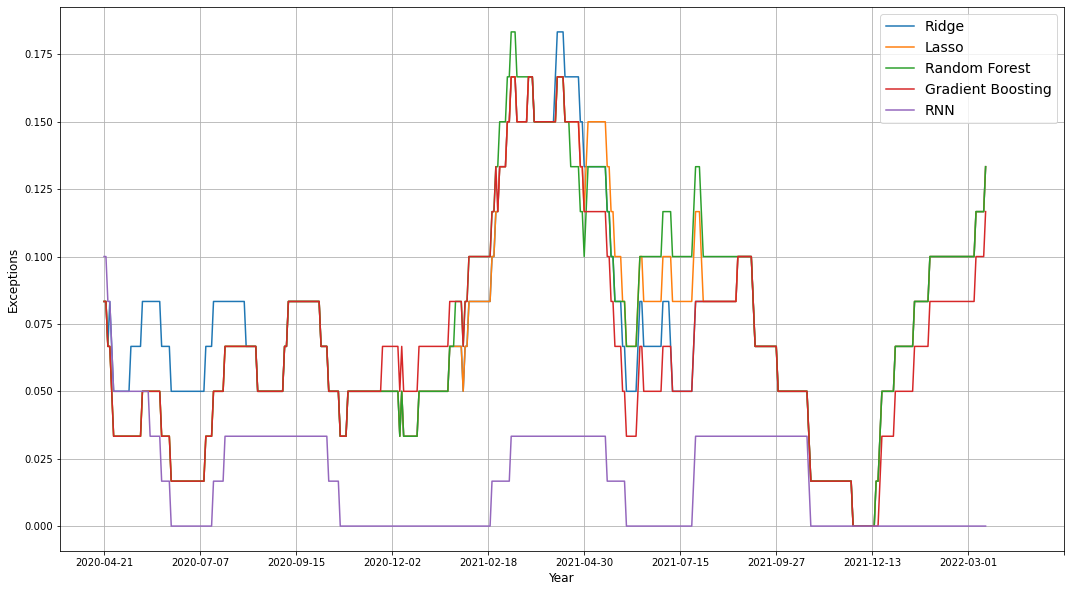

In [69]:
MLexceptionsMA1 = MLexceptions.rolling(window = 60).mean()

plt.figure(figsize=(18,10))
plt.plot(MLexceptionsMA1[60:])

plt.legend(['Ridge','Lasso','Random Forest','Gradient Boosting','RNN'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(test)+1, 50))
plt.grid()

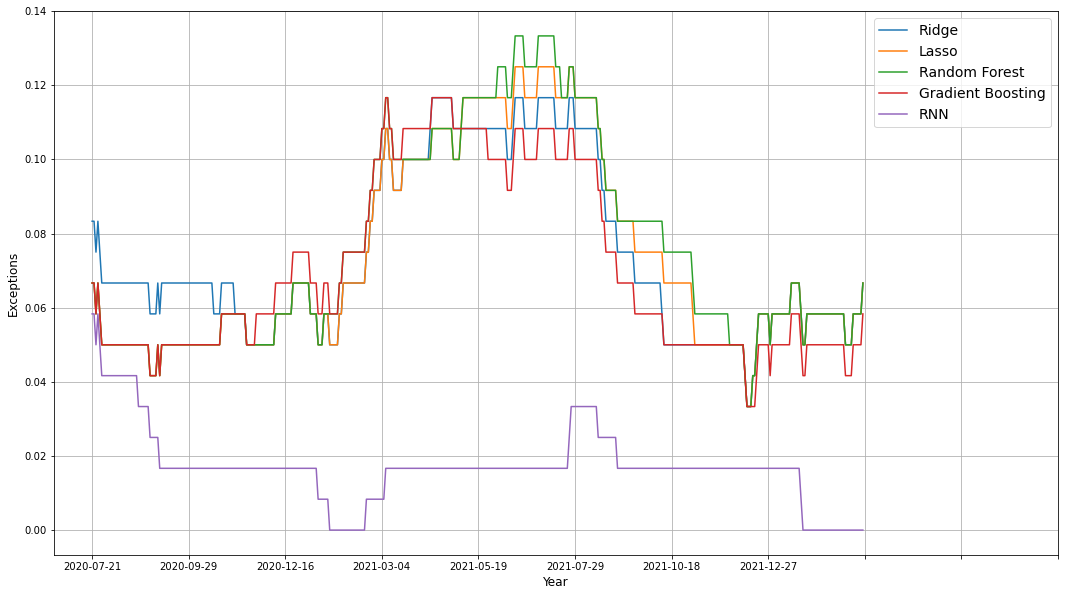

In [67]:
MLexceptionsMA2 = MLexceptions.rolling(window = 120).mean()

plt.figure(figsize=(18,10))
plt.plot(MLexceptionsMA2[120:])

plt.legend(['Ridge','Lasso','Random Forest','Gradient Boosting','RNN'],fontsize = 14,loc='upper right')
plt.xlabel('Year',fontsize = 12)
plt.ylabel('Exceptions',fontsize = 12)
plt.xticks(np.arange(0, len(test)+1, 50))
plt.grid()

In [62]:
OV3 = list(np.sum(MLexceptions))
pT = 0.025*len(test)
VR3 = []
for o in OV3:
    VR3 += [o/pT]
print('OOS VR: ',VR3)

OOS VR:  [3.1538461538461537, 3.076923076923077, 3.1538461538461537, 2.923076923076923, 0.9230769230769231]
